## Pings Data and Problem:

When the app is opened by a user, the app pings the analytics system. A user may ping multiple times in a day. <br>

***data.json *** <br>
    date: date of the ping <br>
    timestamp: ping timestamp <br>
    userId: unique id assigned to users that are registered and signed in <br>
    containerId: unique id assigned to the user's device, even if user is not signed in <br>
    isFirst: true if this is the user's first ping ever (some users have been suing the app before February) <br>

# Information about the computer I used to run this code (CPython is my python version).

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,itertools,matplotlib,seaborn,sklearn -g

CPython 2.7.13
IPython 5.1.0

numpy 1.11.3
scipy 0.18.1
itertools n
matplotlib 2.0.0
seaborn 0.7.1
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [2]:
import pandas as pd
import numpy as np
import ijson
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

Here is how I structured the analyses reported in this note. 

1. [Import Data](#Import Data)
2. [Data Cleaning](#Data Cleaning)
3. [Daily Active Users](#Active Users)
4. [Daily Retention Curve](#Retention Curve)
5. [Source segmentation](#Source segmentation)
6. [Suggestions](#Suggestions)

# Import data <a name="Import data"></a>

*** Since the data is relatively large, I use ijson to import the data to python in chunks. ***

In [4]:
data = []
columns = ["date", "timestamp", "userId", "containerId", "isFirst", "utmSource"]
filename = 'Data/data.json'
with open(filename, 'r') as f:
    objects = ijson.items(f, "item")
    for row in objects:
        selected_row = []
        for item in columns:
            selected_row.append(row[item])
        data.append(selected_row)

In [5]:
pings = pd.DataFrame(data, columns=columns)
pings.head()

,date,timestamp,userId,containerId,isFirst,utmSource
0,2016-02-29,1456732801255,None,0fe180bt0tg8,False,SummerInvite
1,2016-02-29,1456732801556,None,0fe180bt0tg8,False,SummerInvite
2,2016-02-29,1456732801770,51011572,970hdS3gGgVL,False,Grub+Street
3,2016-02-29,1456732803129,None,9opEQ2qF1Si0,False,None
4,2016-02-29,1456732803610,50832445,49Q925xl898M,False,None


In [6]:
for column in pings.columns.values:
    print ("{}: {}".format(column, pd.unique(pings[column]).size))

date: 29
timestamp: 4802369
userId: 180010
containerId: 261126
isFirst: 2
utmSource: 53


In [7]:
pd.isnull(pings).sum() > 0

date           False
timestamp      False
userId          True
containerId    False
isFirst        False
utmSource       True
dtype: bool

# Data Cleaning <a name="Data Cleaning"></a>

In [8]:
# Sort the dataframe based on time ascending
pings = pings.sort_values('timestamp')

In [9]:
# Remove duplicated rows
pings = pings[~pings.duplicated()]

In [10]:
# Fill the None values in the source column as Unknown
pings['utmSource'].fillna(value = 'unknown', inplace = True)

In [11]:
# Find the users that have switched the source during their interaction with the app 
# There are about 3000 of them and I remove them since I don't know how the data is collected 
# and how a source being None initially and then something else means two different things or not
dh = pings.groupby(['containerId']).agg({'utmSource': 'nunique'}) >1
dh.reset_index(inplace = True)

In [12]:
multi_devices = dh[dh['utmSource']== True]['containerId']
mask = pings['containerId'].isin(multi_devices)
pings = pings[~mask]

In [13]:
# I do not expect same user to be 'isFirst' twice with the same ID, 
# but this is seen in about 30 users, so I'll remove them
mask = (pings['isFirst'] == True) 
temp = pings[mask].groupby(['containerId']).agg({'containerId':'cumcount'})
temp.reset_index(inplace=True)
pings.loc[temp[temp['containerId']>0]['index'],'isFirst'] = False

In [14]:
# Extracting dates and day of week
pings['date'] = pings['date'].apply(lambda d: pd.to_datetime(d))
pings['day_of_week'] = pings['date'].apply(lambda d: d.dayofweek)
pings['date'] = pings['date'].dt.date

# Daily Active Users <a name="Active Users"></a>

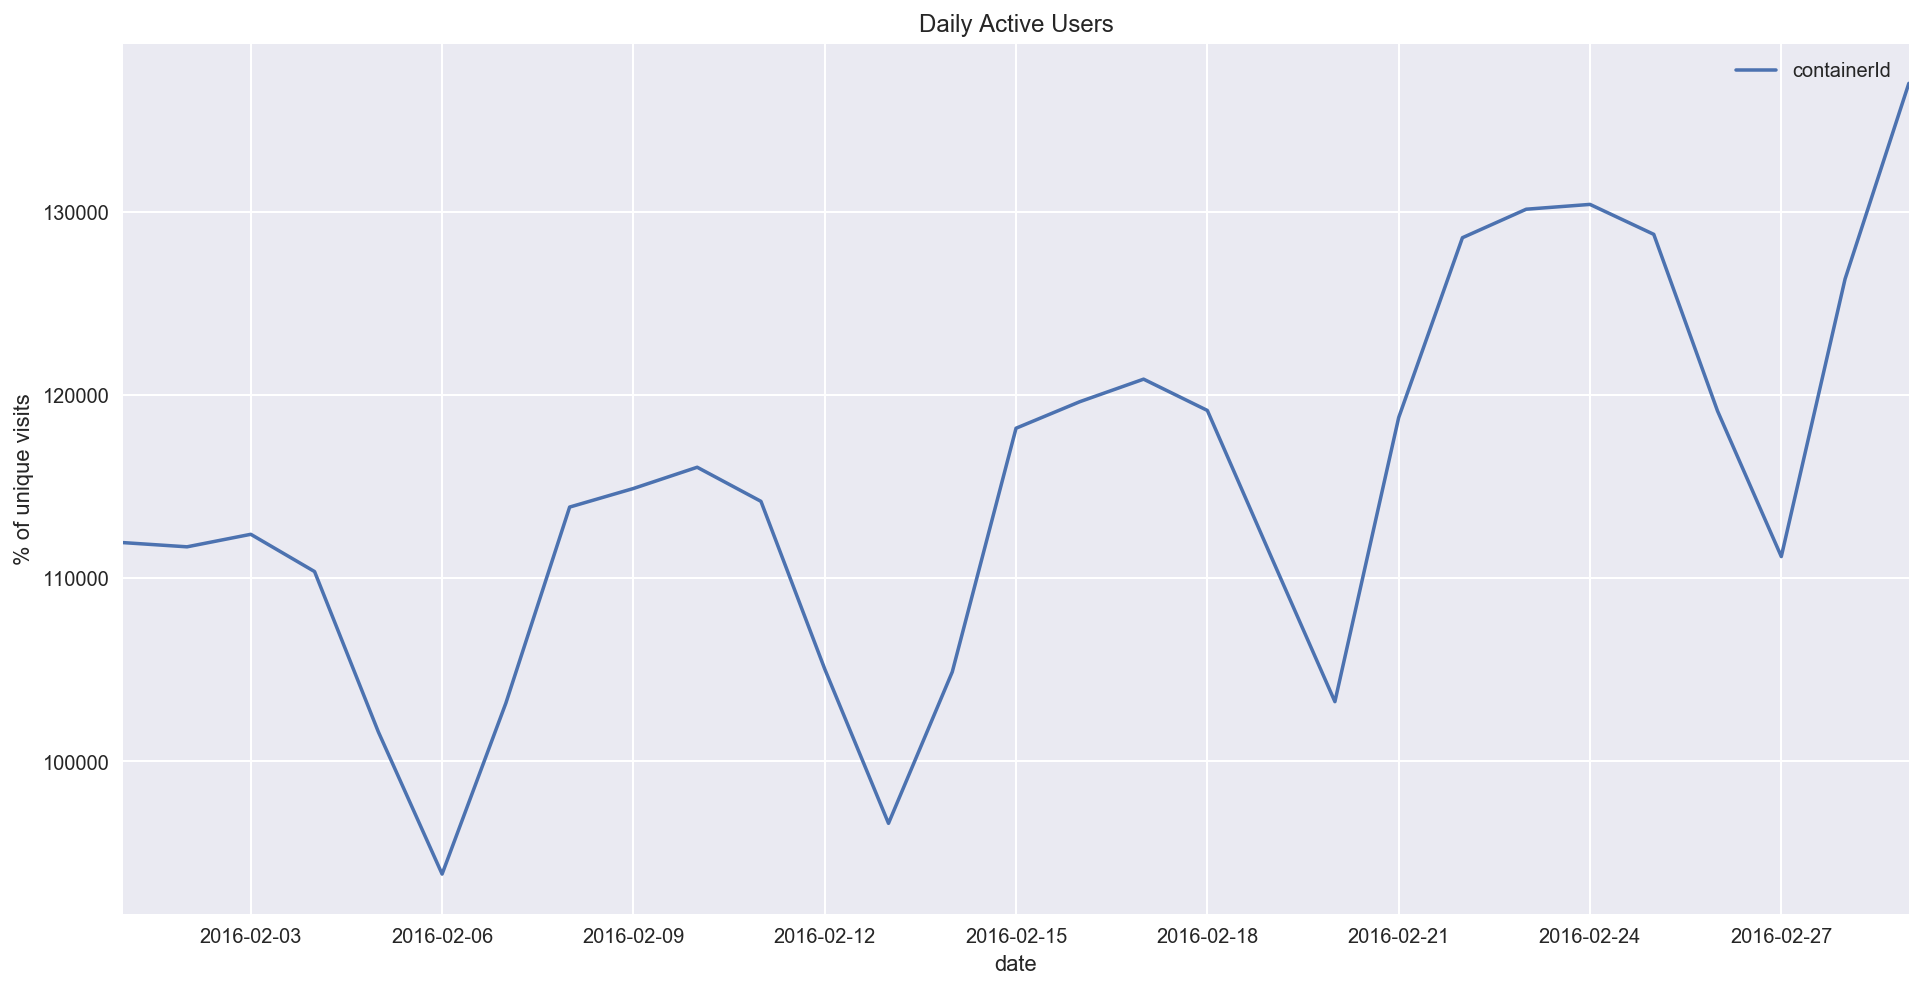

In [18]:
pings.groupby(['date']).agg({'containerId': 'nunique'}).plot(figsize=(16,8))
plt.title('Daily Active Users')
plt.ylabel('% of unique visits');
plt.savefig('daily_active_users.png',bbox_inches='tight') 

*** There is clear periodicity in the data, so lets group by day of the week. ***

## Monday has the biggest number of visits

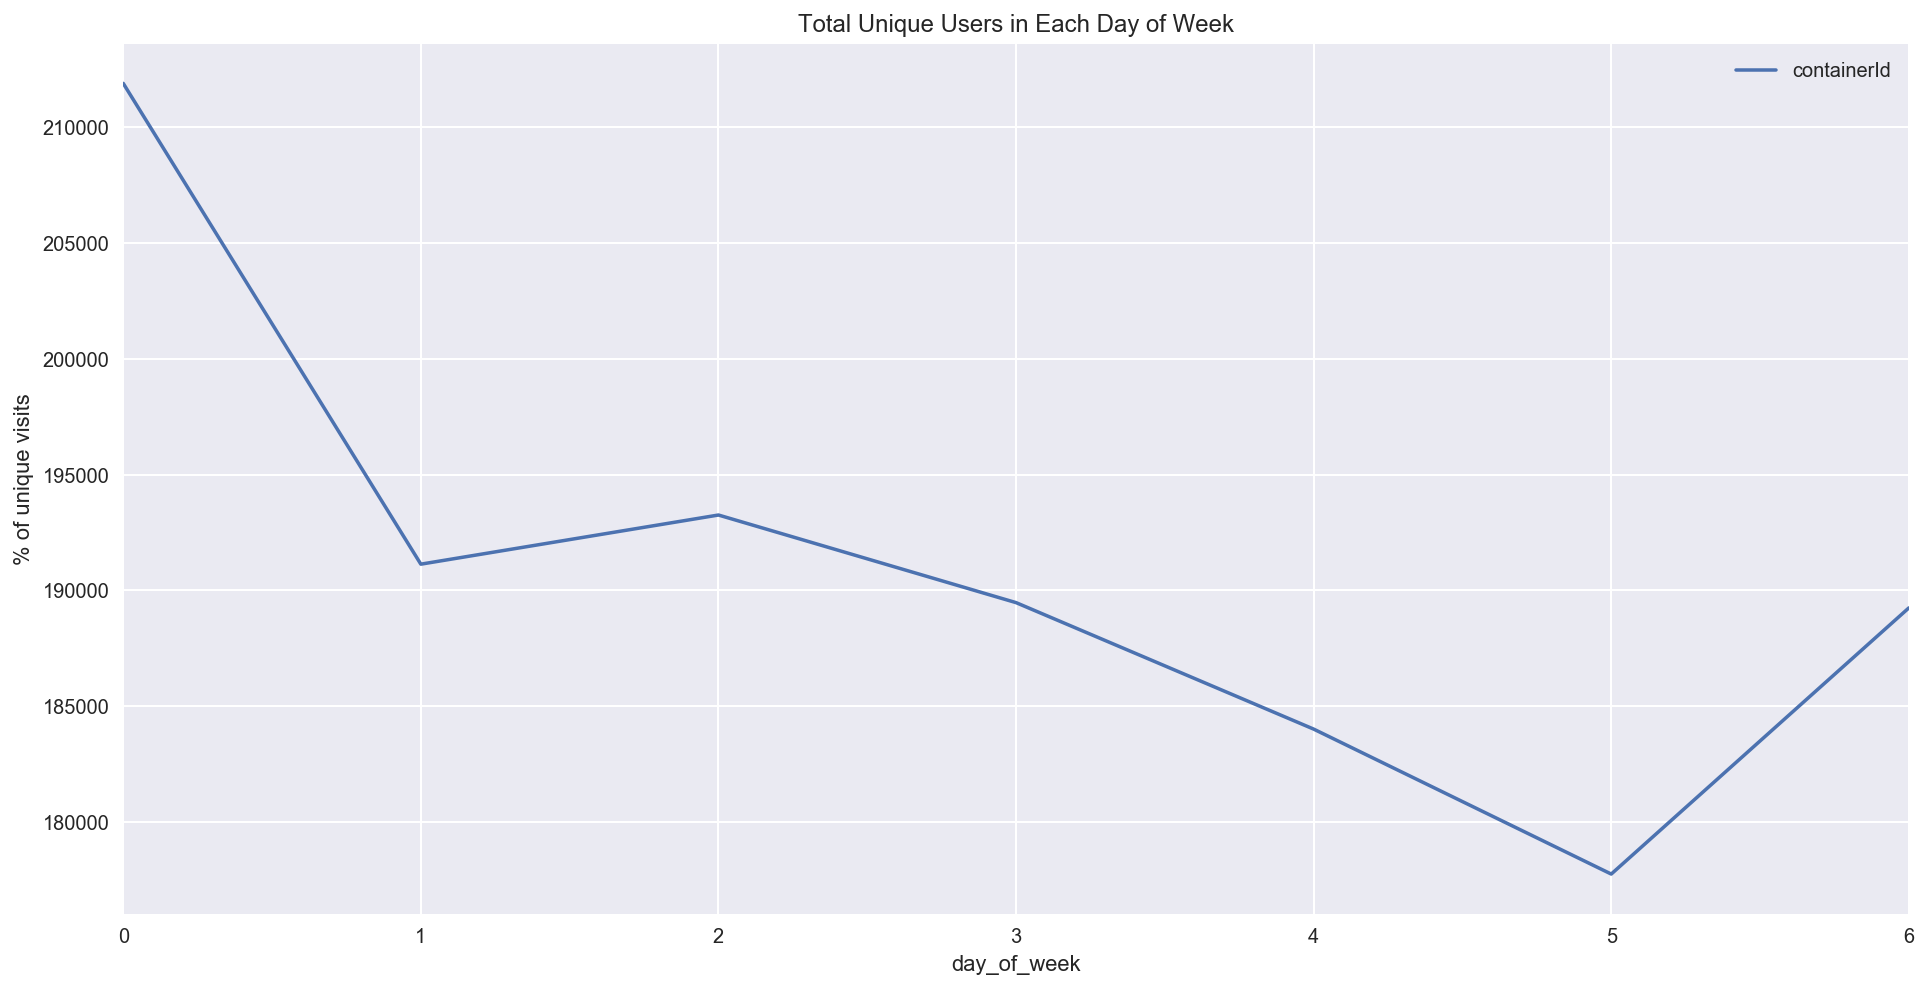

In [20]:
pings.groupby(['day_of_week']).agg({'containerId': 'nunique'}).plot(figsize=(16,8))
plt.title('Total Unique Users in Each Day of Week')
plt.ylabel('% of unique visits');
plt.savefig('dayofweek_active_users.png',bbox_inches='tight') 

# Daily Retention Curve <a name="Retention Curve"></a>

In [21]:
mask = pings['isFirst'] == True
first_visited = pings[mask]

In [22]:
pings2 = pd.merge(pings, first_visited, how='left', left_on='containerId', right_on='containerId')

In [23]:
pings2 = pings2.rename(columns = {'date_x': 'visit_day', 'userId_x': 'userId', 
                                  'date_y': 'first_visit_day', 'utmSource_x': 'utmSource'})
select_columns = ['visit_day','userId','containerId', 'first_visit_day', 'utmSource']
pings2 = pings2[select_columns]
pings2 = pings2[~pings2['first_visit_day'].isnull()]

In [24]:
# Example of a user that visited first and has signed up later
pings2[pings2.containerId == 'j3H416Wft2h4'][:5]

,visit_day,userId,containerId,first_visit_day,utmSource
26,2016-02-01,None,j3H416Wft2h4,2016-02-01,unknown
27,2016-02-01,None,j3H416Wft2h4,2016-02-01,unknown
59,2016-02-01,57908723,j3H416Wft2h4,2016-02-01,unknown
142434,2016-02-01,57908723,j3H416Wft2h4,2016-02-01,unknown
254253,2016-02-02,57908723,j3H416Wft2h4,2016-02-01,unknown


In [25]:
pings2['day_nth'] = pings2['visit_day']-pings2['first_visit_day']
pings2['day_nth'] = pings2['day_nth'].dt.days

In [26]:
dg = pings2.groupby(['first_visit_day', 'day_nth']).agg({'containerId':'nunique'})
dg.head()

containerId
first_visit_day day_nth             
2016-02-01      0               2968
                1               1752
                2               1569
                3               1455
                4               1256

In [27]:
group_size = dg['containerId'].groupby(level=0).first()

In [28]:
user_table = dg['containerId'].unstack(0).divide(group_size, axis=1)
user_table.head()

first_visit_day,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,...,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29
day_nth,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.590296,0.580813,0.576716,0.534039,0.507834,0.548804,0.595803,0.608802,0.585786,0.596966,...,0.618300,0.651955,0.632990,0.641232,0.628306,0.573596,0.545627,0.624464,0.629808,NaN
2,0.528639,0.507473,0.489041,0.430408,0.476498,0.502871,0.546444,0.537548,0.509332,0.500000,...,0.556279,0.589385,0.572319,0.559101,0.529497,0.478907,0.520257,0.556291,NaN,NaN
3,0.490229,0.428571,0.411067,0.452723,0.491705,0.442584,0.518850,0.479567,0.425700,0.429420,...,0.530628,0.555028,0.526273,0.480577,0.468759,0.495599,0.528209,NaN,NaN,NaN
4,0.423181,0.389642,0.430830,0.466717,0.460829,0.433014,0.477653,0.438002,0.366116,0.456794,...,0.511485,0.530726,0.458288,0.443119,0.505086,0.527466,NaN,NaN,NaN,NaN


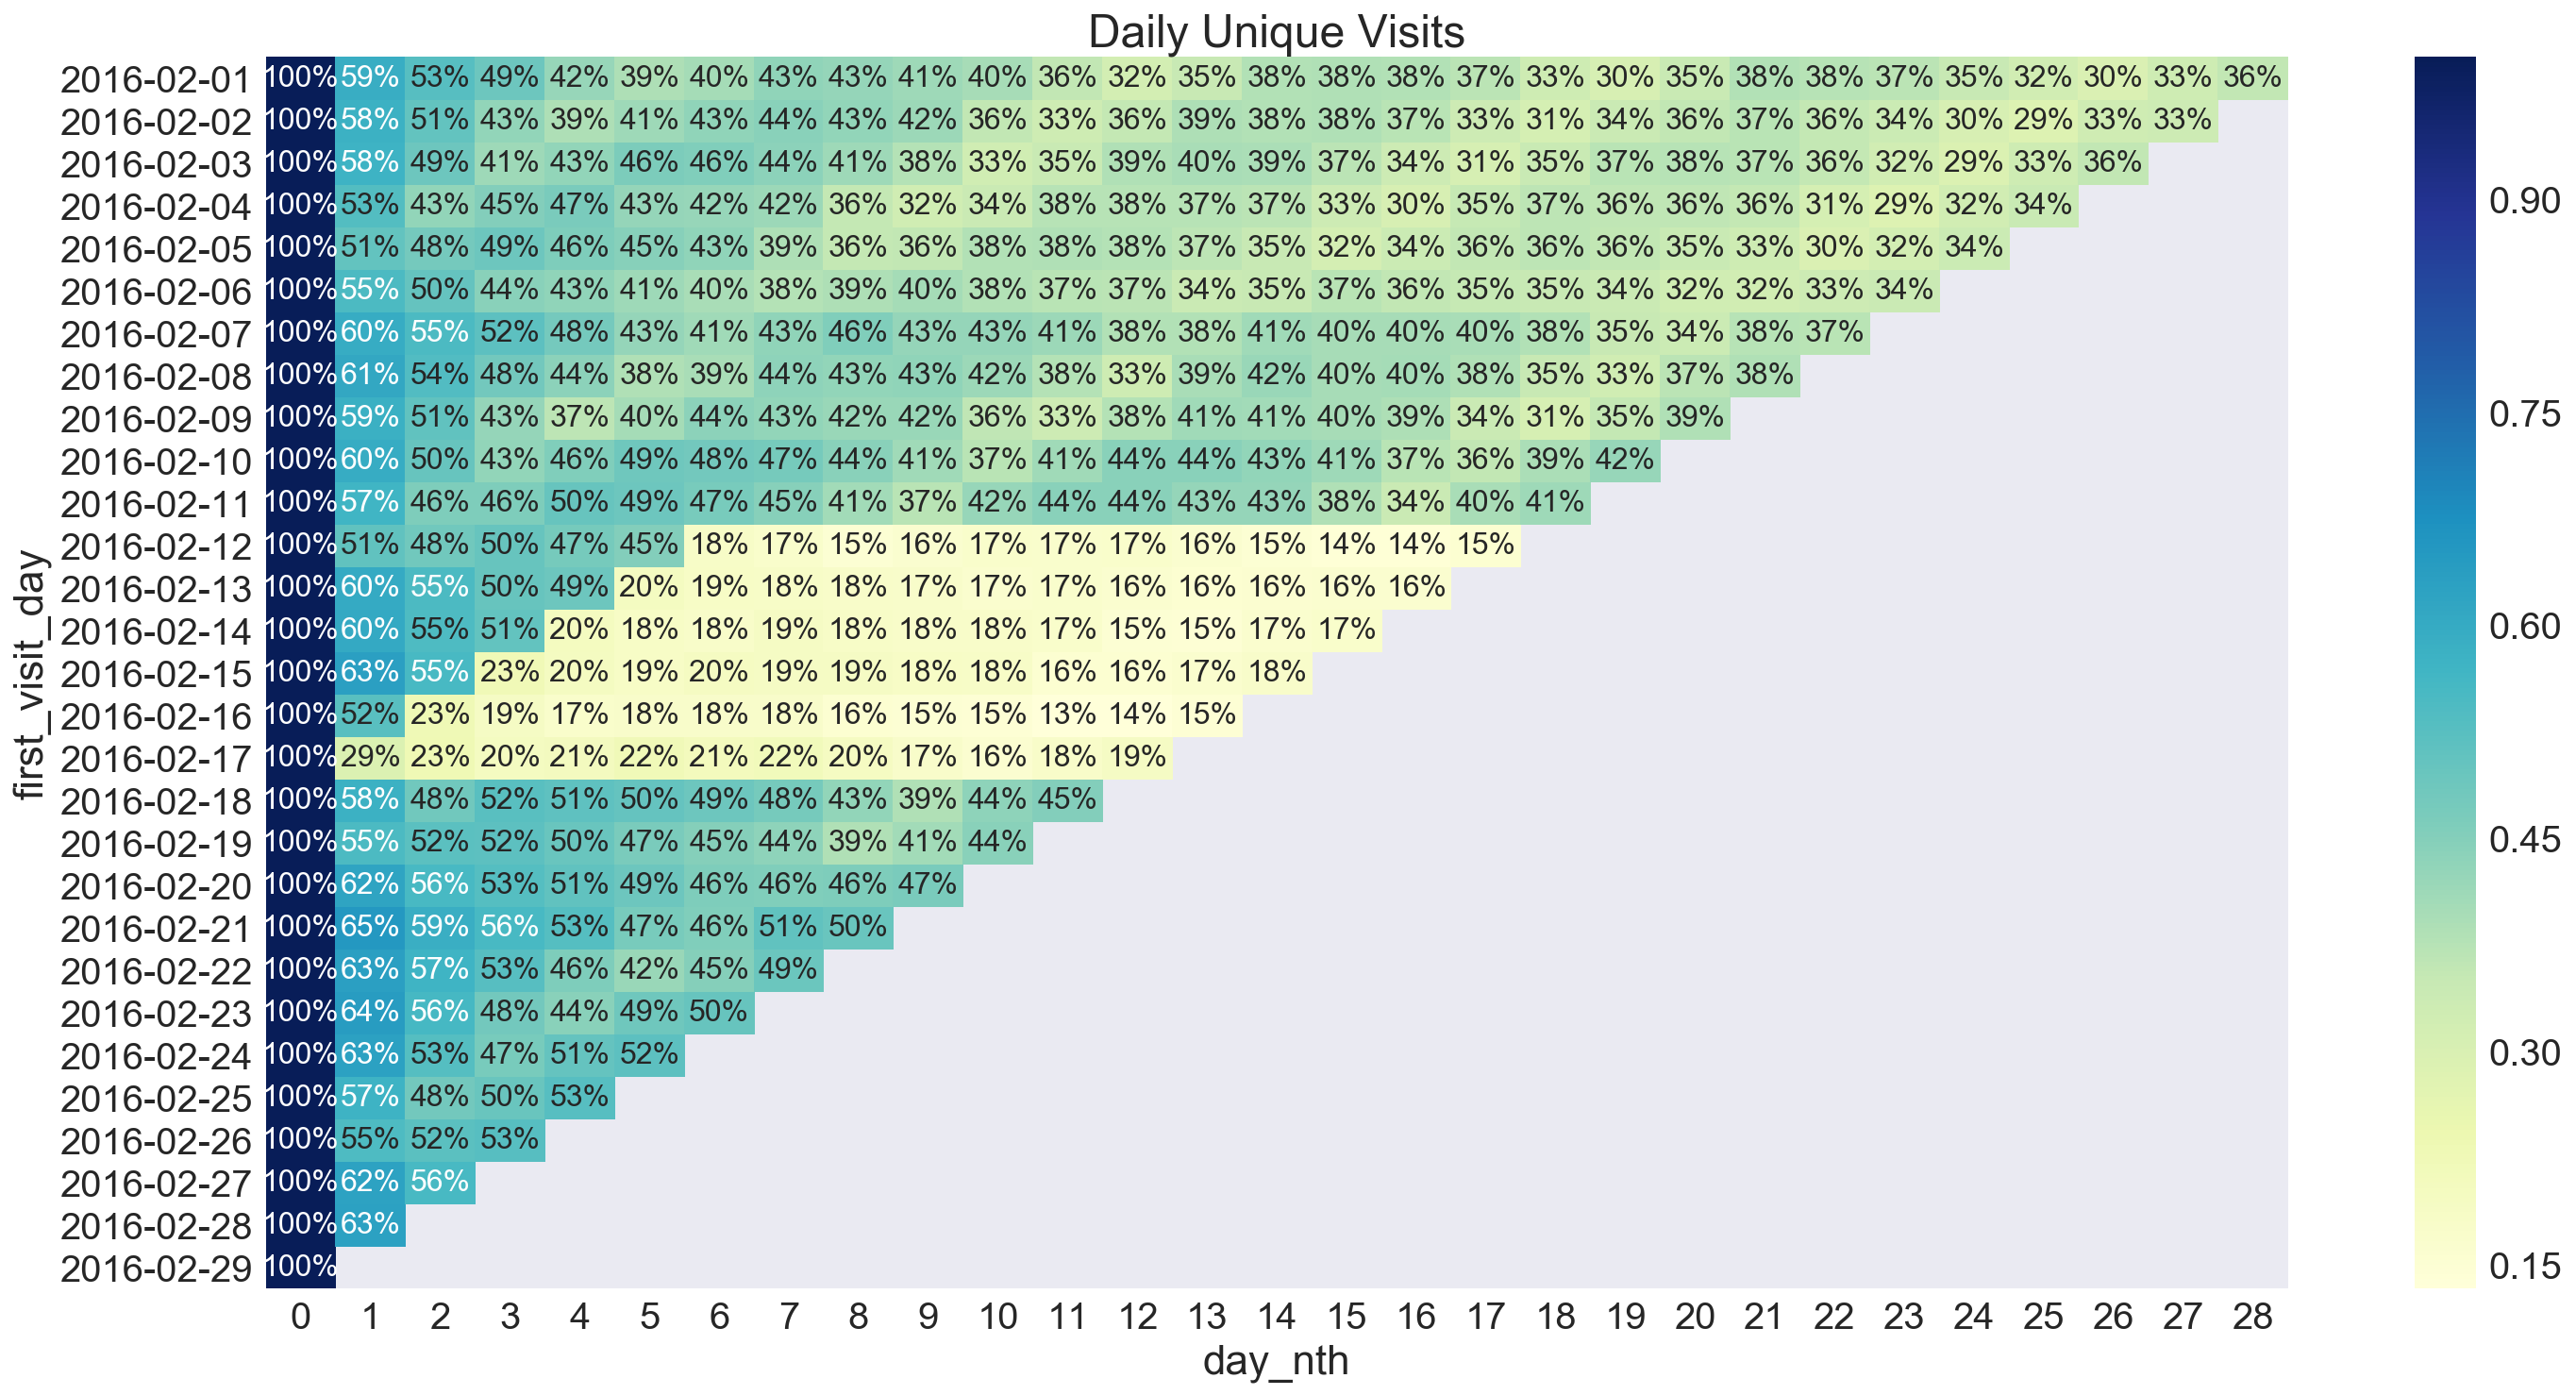

In [29]:
sns.set(context="paper", font="monospace")
sns.set(font_scale=2.0)
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(24, 12))

# Draw the heatmap using seaborn
plt.title('Daily Unique Visits')
sns.heatmap(user_table.T, mask=user_table.T.isnull(), annot=True, fmt='.0%', cmap="YlGnBu", annot_kws={"size": 16});
plt.savefig('heartmap_first_visits.png',bbox_inches='tight') 

*** Another interesting heatmap for future study would be for users who visited first, what proportion of them came back for the "first time" within first day, for first time within second day etc. and what proportion of users don’t come back even after a month.  ***

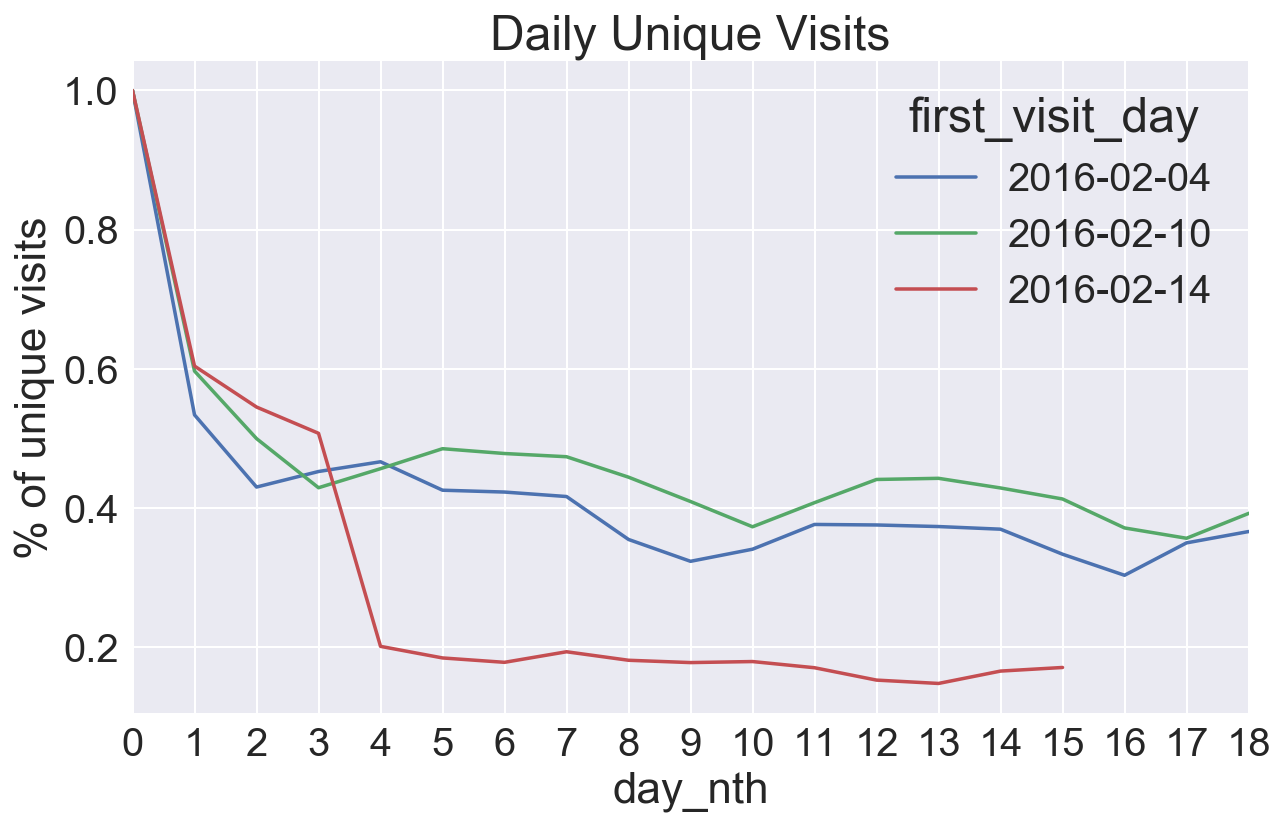

In [31]:
user_table.iloc[:,[3,9,13]].plot(figsize=(10, 6))
plt.title('Daily Unique Visits')
plt.xticks(np.arange(0, 18.1, 1))
plt.xlim(0, 18)
plt.ylabel('% of unique visits');
plt.savefig('daily_unique_visits.png',bbox_inches='tight') 

# Source segmentation <a name="Source segmentation"></a>

*** Best users for sources has to be defined: is it total number of users they bring, or total number of registered users or users that show more retention, etc. ***

In [32]:
dg = pings.groupby(['date', 'utmSource']).agg({'containerId': 'nunique'})
dg = dg.reset_index()

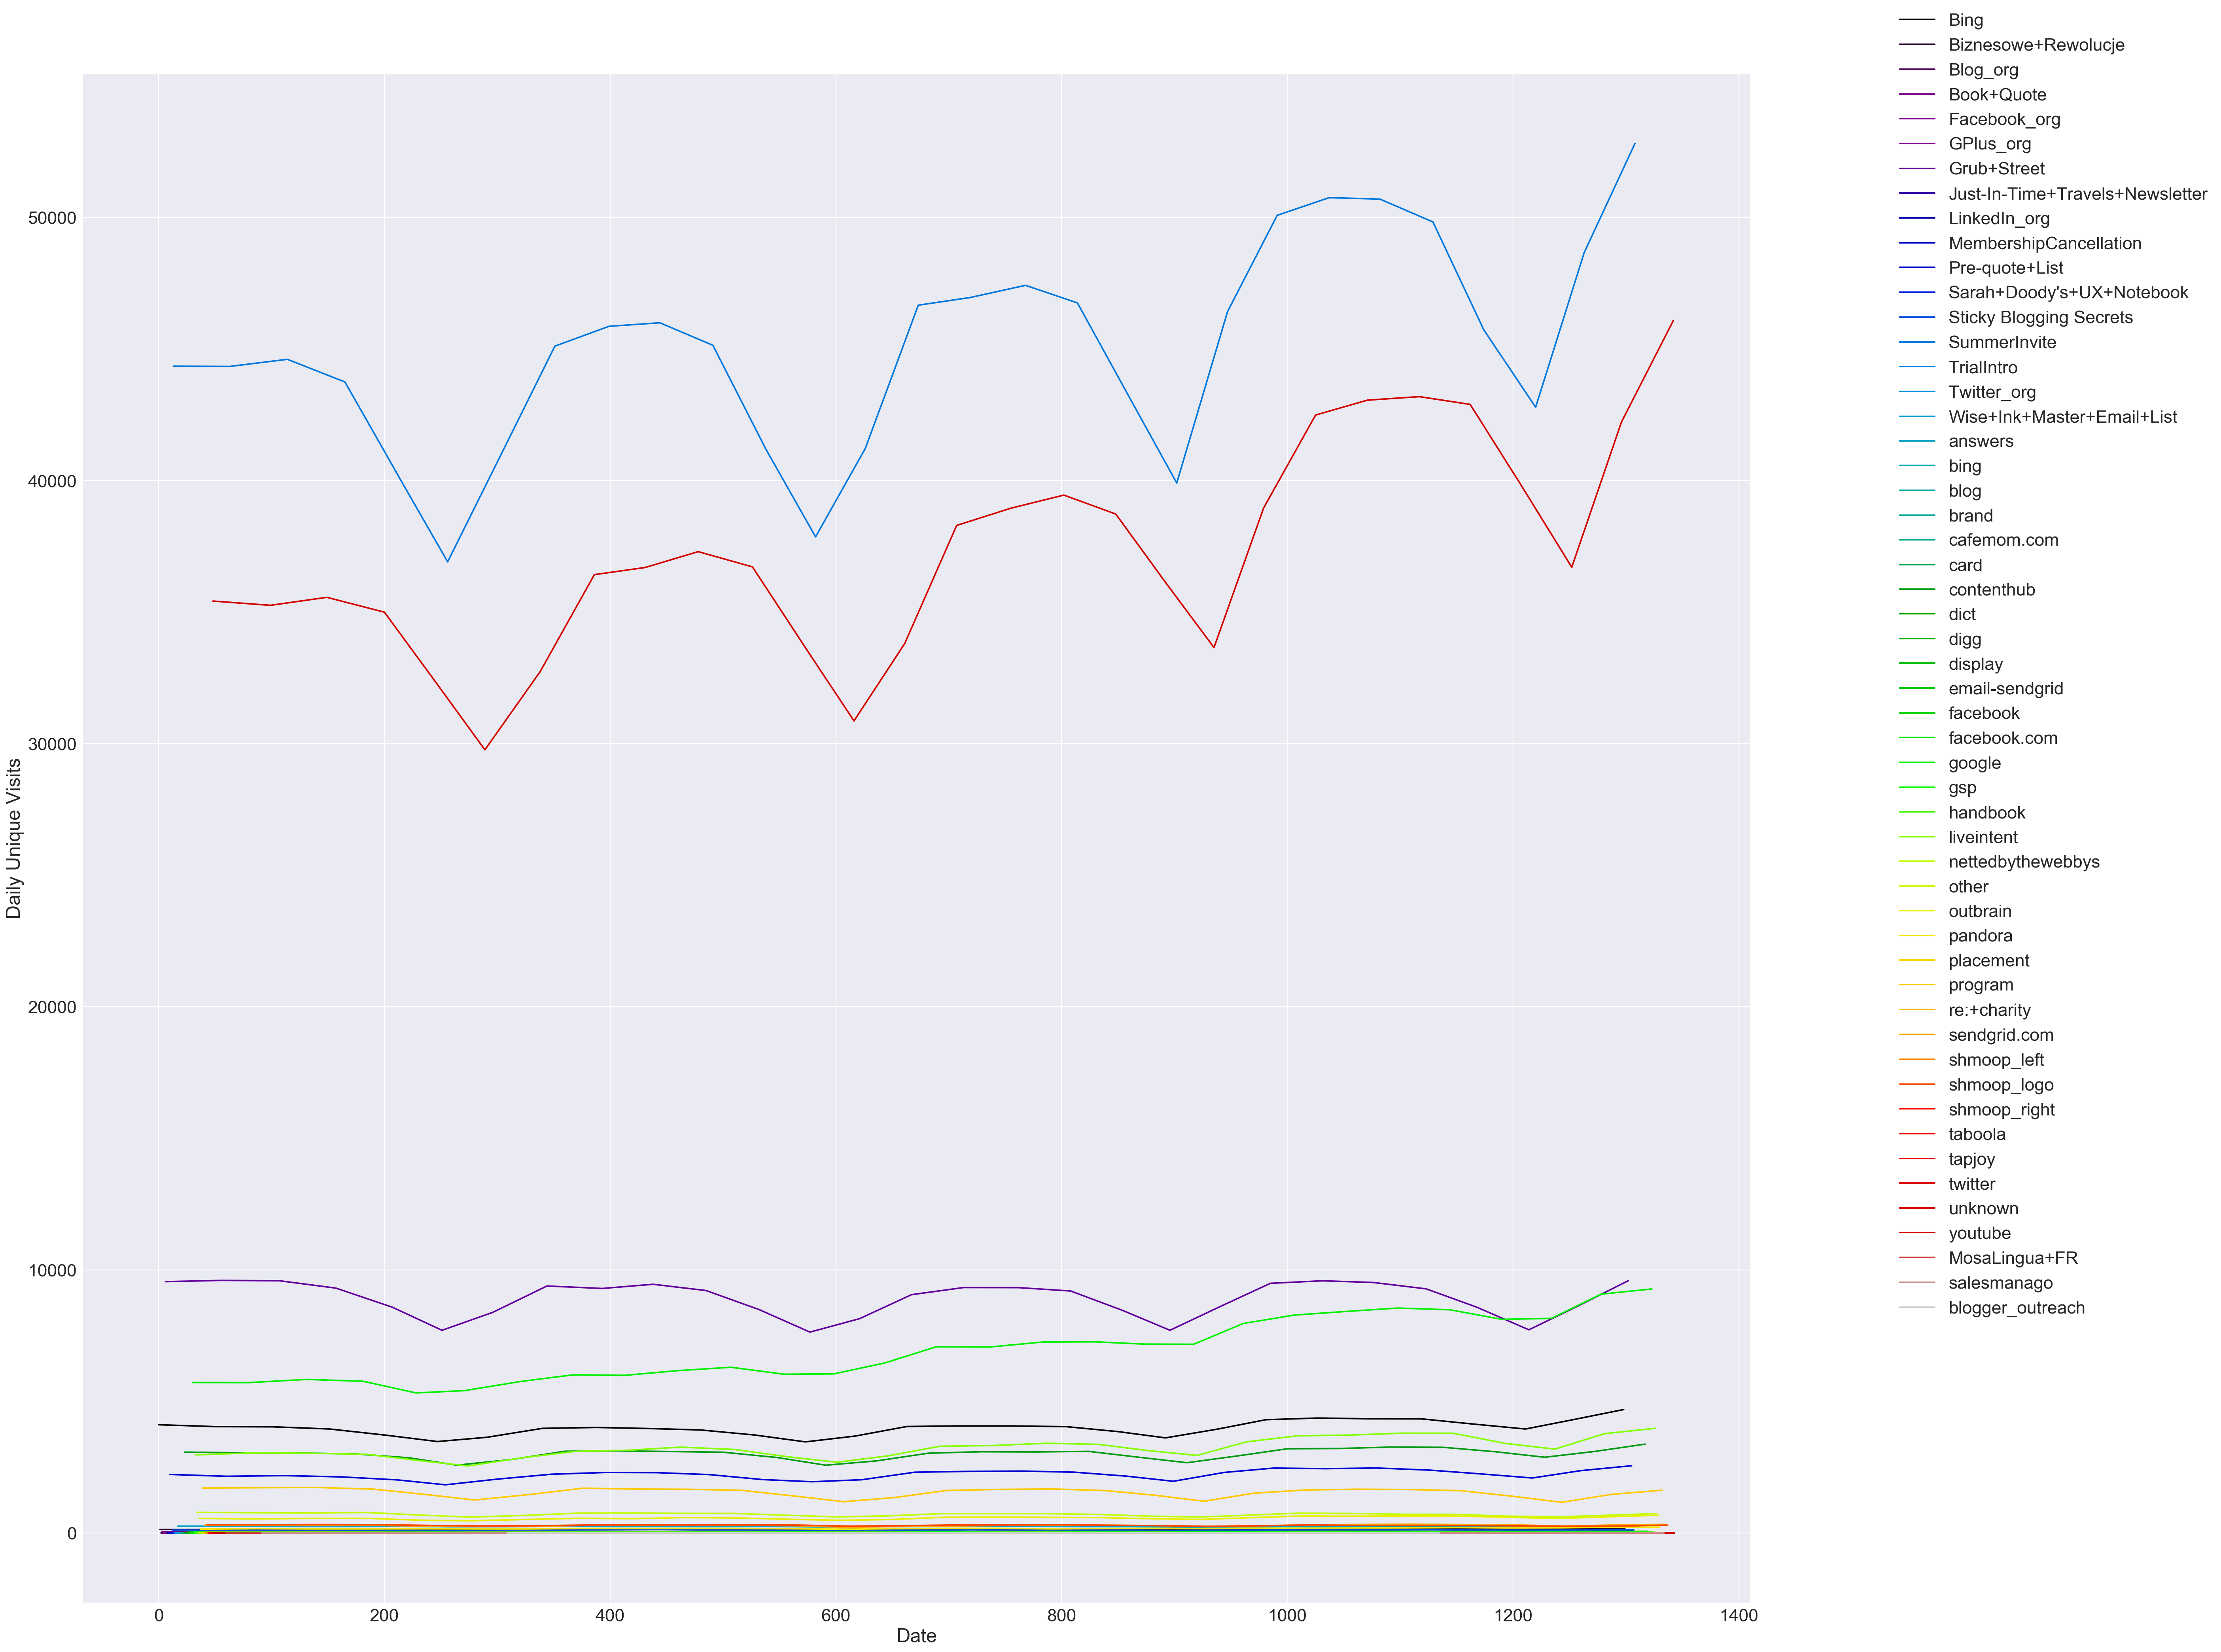

In [33]:
def plot_daily_clicks(df):
    
    fig, ax = plt.subplots(figsize=(34, 32), dpi=80)
    
    kinds = pd.unique(df['utmSource'])
    cmap = plt.get_cmap('nipy_spectral')
    colors = cmap(np.linspace(0, 1.0, len(kinds)))

    for key, color in zip(kinds, colors):
        
        cum = df[df['utmSource'] == key]['containerId']
        ax.plot(cum, label = key, color=color) 
        ax.set_xlabel("Date")
        ax.set_ylabel('Daily Unique Visits')
        ax.legend(bbox_to_anchor=(1.08, 1.05))
        
plot_daily_clicks(dg)

In [34]:
pings_A = pings2[pings2['utmSource']=='SummerInvite']
pings_B = pings2[pings2['utmSource']=='Grub+Street']
pings_C = pings2[pings2['utmSource']=='google']

In [35]:
dg_A = pings_A.groupby(['first_visit_day', 'day_nth']).agg({'containerId':'nunique'})
dg_B = pings_B.groupby(['first_visit_day', 'day_nth']).agg({'containerId':'nunique'})
dg_C = pings_C.groupby(['first_visit_day', 'day_nth']).agg({'containerId':'nunique'})

In [36]:
group_size_A = dg_A['containerId'].groupby(level=0).first()
group_size_B = dg_B['containerId'].groupby(level=0).first()
group_size_C = dg_C['containerId'].groupby(level=0).first()

In [37]:
user_table_A = dg_A['containerId'].unstack(0).divide(group_size_A, axis=1)
user_table_B = dg_B['containerId'].unstack(0).divide(group_size_B, axis=1)
user_table_C = dg_C['containerId'].unstack(0).divide(group_size_C, axis=1)

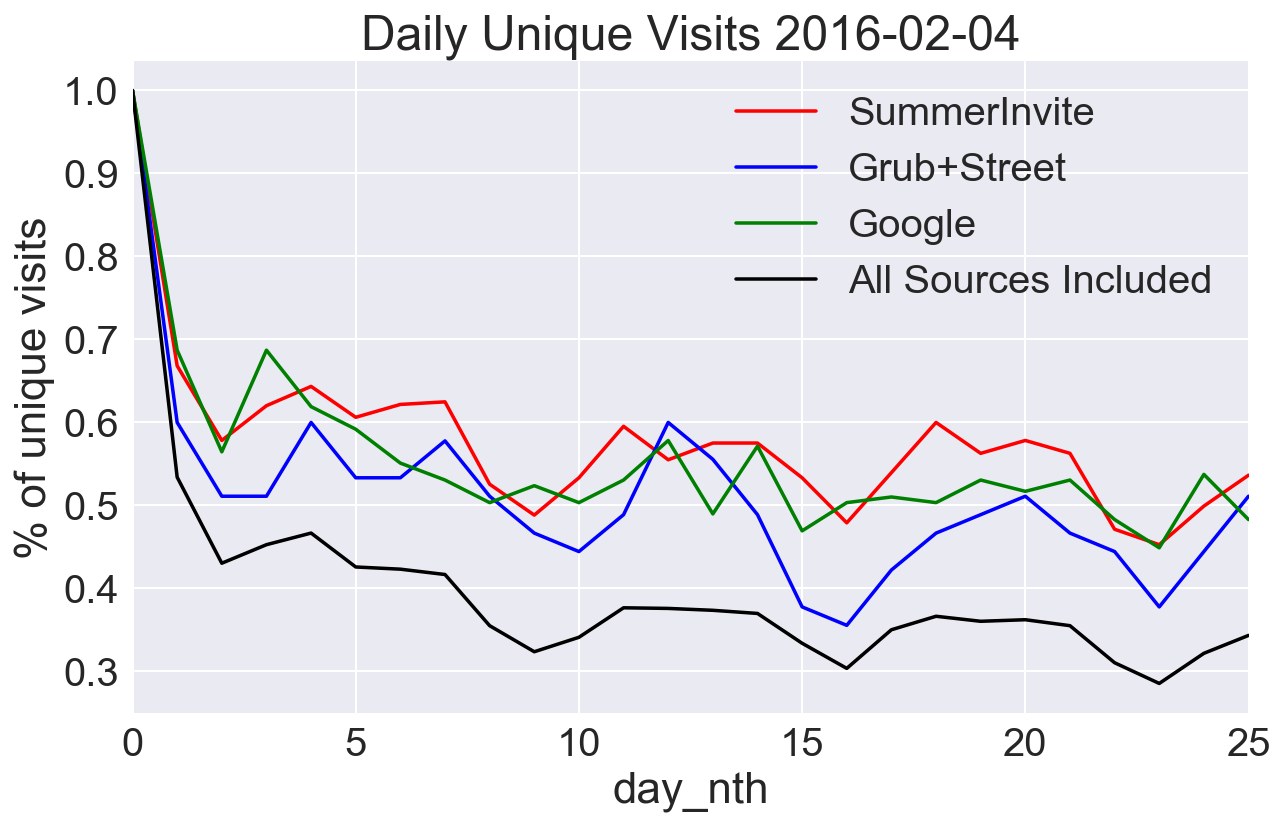

In [38]:
user_table_A.iloc[:,3].plot(figsize=(10, 6), color = 'r', label = 'SummerInvite')
user_table_B.iloc[:,3].plot(figsize=(10, 6), color ='b', label = 'Grub+Street')
user_table_C.iloc[:,3].plot(figsize=(10, 6),color = 'g', label = 'Google')
user_table.iloc[:,3].plot(figsize=(10, 6), color ='k', label = 'All Sources Included')

plt.title('Daily Unique Visits 2016-02-04')
plt.legend()
plt.xlim(0, 25)
plt.ylabel('% of unique visits')
plt.savefig('daily_unique_visits_02-04.png',bbox_inches='tight')

In [39]:
dg = pings.groupby(['utmSource']).agg({'userId': 'nunique'}).sort_values('userId', ascending = False )

In [40]:
dg.head()

,userId
utmSource,
SummerInvite,75712
unknown,48544
google,14042
Grub+Street,13749
liveintent,5648


*** Similarly one could do the above analysis for the Conversion Rate (CR) given that CR is defined as among the users who visited the app, how many of them became paid users. In addition, one could compute Customer Life Time Value (CLTV) and Churn which I will write about it in the next post...***